Here is a simpler example of the use of LIME for image classification by using Keras (v2 or greater)
https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb

In [16]:
import os
import tensorflow as tf
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.4.0


# Using DenseNet Large
Here we use the trained DenseNet201 Large model and use it on images by first preprocessing them with the preprocessing tools

In [2]:
model = tf.keras.models.load_model('/home/jupyter/Cropping-tuner/DenseNet-LargeDataModel')

In [3]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(224, 224))
        plt.imshow(img)
        x = image.img_to_array(img)/255.0
        x = np.expand_dims(x, axis=0)
        out.append(x)
    return np.vstack(out)

## Let's see the top 5 prediction for some image

0.11870738
0
Good


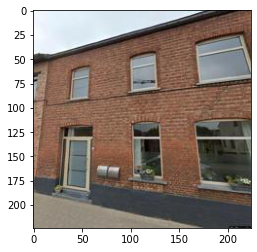

In [5]:
path = '/home/jupyter/large-dataset/test-data-large/Good/0255fd-f311-4a7e-9e9e-3b37b856e1da.jpg'
images = transform_img_fn([path])
preds = model.predict(images)
print(preds[0][0])
p = (preds[0][0] > 0.5).astype(np.int)
print(p)
if p==1:
    predicted_label = 'Bad'
elif p==0:
    predicted_label = 'Good'
print(predicted_label)

## Explanation
Now let's get an explanation

In [6]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [7]:
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [8]:
%%time
with tf.device("/gpu:0"):
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
    explanation = explainer.explain_instance(images[0].astype('double'), model.predict, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 27.2 s, sys: 4.93 s, total: 32.1 s
Wall time: 31.4 s


In [9]:
print(explanation.top_labels[0])
print(explanation.top_labels)

0
[0]


Image classifiers are a bit slow. Notice that an explanation on my Surface Book dGPU took 1min 12s

### Now let's see the explanation for the top class (Good)

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [10]:
from skimage.segmentation import mark_boundaries

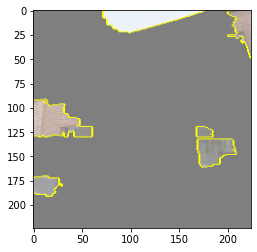

In [11]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or with the rest of the image present:

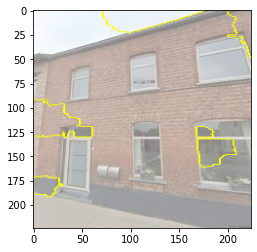

In [12]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


We can also see the 'pros and cons' (pros in green, cons in red). So red indicate Good state

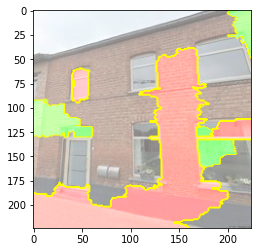

In [13]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or the pros and cons that have weight at least 0.1

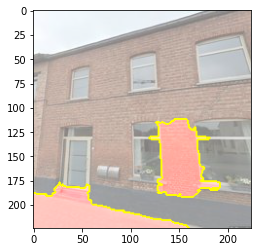

In [14]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Alternatively, we can also plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.

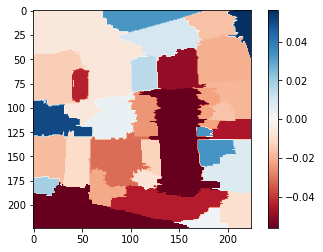

In [15]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

### Let's see the explanation for the second highest prediction (doesn't work)

Most positive towards wombat:

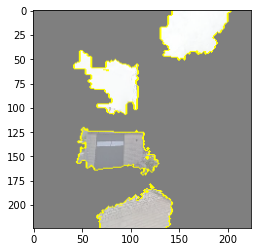

In [16]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

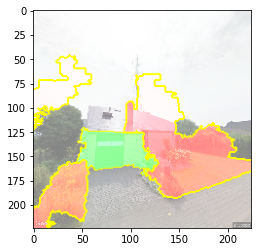

In [17]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
